In [62]:
import cv2
import pandas as pd
import numpy as np
import os
from skimage.io import imread, imshow

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from mtcnn import MTCNN
import time

from imutils import face_utils
import numpy as np
import imutils
import dlib
import skimage
import cv2
import matplotlib.pyplot as plt
import heartpy as hp


In [63]:
videoPath = './Project Videos/set1/video_front.mp4'
groundTruth = pd.read_csv('./Project Videos/set1/MPDataExport.csv')

In [39]:
# with open('./Project Videos/set3/ground_truth24.txt') as f:
#     content = f.read()
# groundTruth = content.split()
# groundTruth = np.array(groundTruth).astype('float32')

In [64]:
classifierPath = "./haarcascade.xml"
haar_cascade = cv2.CascadeClassifier(classifierPath)

In [5]:
import heartpy as hp

def prHeartPy(signal, sample_rate, lpf = 0.7, hpf = 3.3, plotTF = True): 
    
    filtered = hp.filter_signal(signal, [lpf, hpf], sample_rate=sample_rate,
                               order = 3, filtertype='bandpass')
    wd, measures = hp.process(filtered, sample_rate)
    if plotTF: 
        plt.figure(figsize=(12,4))
        hp.plotter(wd, measures)
        print('Measures:')
        for m in measures.keys():
            print('%s: %f' %(m, measures[m]))
    
    PR = measures['bpm']
    
    return PR

In [65]:
# Preprocessing functions
# Can use MTCNN

def haar_faces(img, haar_classifier):
    face_params = dict(scaleFactor=1.1, 
                   minNeighbors=9,
                   flags=cv2.CASCADE_SCALE_IMAGE)
    # Detect faces using classifier.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = haar_classifier.detectMultiScale(gray, **face_params)
    
    if len(faces) == 0:
        return []
    # selecting the face with max area
    sizes = [h*w for x, y, w, h in faces]
    face_idx = np.argmax(sizes)
    face_max = faces[face_idx]
    return face_max

# Crop the image face out
def crop_face(img, face):
    newimg = img[face[1] + int(0.1 * face[3]):face[1] + int(0.9 *face[3]),
                 face[0] + int(0.25*face[2]) : face[0] + int(0.75*face[2])]       
    return newimg

def crop_faceMTCNN(img, face):
    newimg = img[face[1] :face[1] + face[3],
                 face[0] : face[0] + face[2]]       
    return newimg

def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def ret_face(frame, cascadeHaar):
    rect = haar_faces(frame, haar_cascade)
    if len(rect) == 0:
        return []
    face_only = crop_face(frame, rect)
    face_only = cv2.cvtColor(face_only, cv2.COLOR_BGR2RGB)
    return face_only

detector = MTCNN()
sPred = './shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(sPred)

def ROISkinHAAR(frame, haar_classifier):
    face_rect = haar_faces(frame, haar_cascade)
    if len(face_rect) == 0:
        return []
    # rect = patches.Rectangle((face_rect[0],face_rect[1]),face_rect[2],face_rect[3], edgecolor='r', facecolor="none")
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    shp = predictor(gray, dlib.rectangle(face_rect[0],
                                         face_rect[1],
                                         face_rect[0]+face_rect[2],
                                         face_rect[1]+face_rect[3]))

    shp = face_utils.shape_to_np(shp)
    pts = []
    crop_ixs = np.arange(33)+27
    ix = 0
    for ix in crop_ixs:
        # print(ix)
        (x,y) = shp[ix]
        pts.append([x,y])
    pts = np.array(pts)
    nose_pts = pts[0:8,:]
    r_eye_pts = pts[9:15,:]
    l_eye_pts = pts[15:21,:]
    mouth_pts = pts[21:,:]


    mask = 255*np.ones(frame.shape[:2], np.uint8)

    x1,y1,w1,h1 = cv2.boundingRect(r_eye_pts)
    mask[y1:y1+h1,x1:x1+w1] = 0

    #crop left eye
    x2,y2,w2,h2 = cv2.boundingRect(l_eye_pts)
    mask[y2:y2+h2,x2:x2+w2] = 0


    #crop mouth

    x3,y3,w3,h3 = cv2.boundingRect(mouth_pts)
    mask[y3:y3+h3,x3:x3+w3] = 0

    #crop nose
    x4,y4,w4,h4 = cv2.boundingRect(nose_pts)
    mask[y4:y4+h4,x4:x4+w4] = 0
    ROISkinD = cv2.bitwise_and(frame, frame, mask=mask)
    return crop_face(ROISkinD, face_rect)


def ROISkinMTCNN(frame):
    result = detector.detect_faces(frame)

    face_rect = result[0]['box']

    # rect = patches.Rectangle((face_rect[0],face_rect[1]),face_rect[2],face_rect[3], edgecolor='r', facecolor="none")

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    shp = predictor(gray, dlib.rectangle(face_rect[0],
                                         face_rect[1],
                                         face_rect[0]+face_rect[2],
                                         face_rect[1]+face_rect[3]))

    shp = face_utils.shape_to_np(shp)
    pts = []
    crop_ixs = np.arange(33)+27
    ix = 0
    for ix in crop_ixs:
        # print(ix)
        (x,y) = shp[ix]
        pts.append([x,y])
    pts = np.array(pts)
    nose_pts = pts[0:8,:]
    r_eye_pts = pts[9:15,:]
    l_eye_pts = pts[15:21,:]
    mouth_pts = pts[21:,:]


    mask = 255*np.ones(frame.shape[:2], np.uint8)

    x1,y1,w1,h1 = cv2.boundingRect(r_eye_pts)
    mask[y1:y1+h1,x1:x1+w1] = 0

    #crop left eye
    x2,y2,w2,h2 = cv2.boundingRect(l_eye_pts)
    mask[y2:y2+h2,x2:x2+w2] = 0


    #crop mouth

    x3,y3,w3,h3 = cv2.boundingRect(mouth_pts)
    mask[y3:y3+h3,x3:x3+w3] = 0

    #crop nose
    x4,y4,w4,h4 = cv2.boundingRect(nose_pts)
    mask[y4:y4+h4,x4:x4+w4] = 0
    ROISkinD = cv2.bitwise_and(frame, frame, mask=mask)
    return crop_faceMTCNN(ROISkinD, face_rect)




In [66]:
video = cv2.VideoCapture(videoPath)

frame = 0
i = 0
while True:
    ret, frame = video.read()

    if not ret:
        break

    if i == 0:
        break
        
video.release()
cv2.destroyAllWindows()

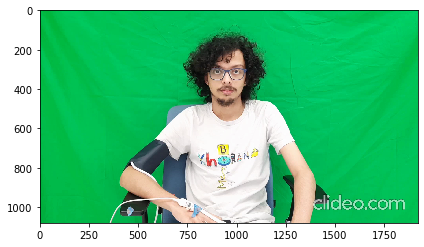

In [69]:
imshow(rgb(frame))

### Using Haar

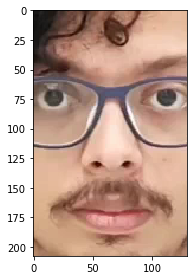

In [67]:
imshow(ret_face(frame, haar_cascade))

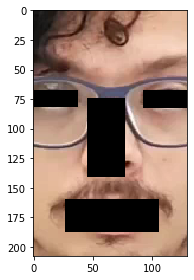

In [70]:
imshow(rgb(ROISkinHAAR(frame,haar_cascade)))

### Using MTCNN

Takes a lot of time and memory for computation. Requires GPU for processing large no. of frames.

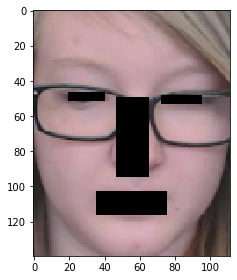

In [9]:
imshow(rgb(ROISkinMTCNN(frame)))

### 2SR Implementation

In [10]:
# helper functions

def getVideoInfo(videoPath):
    cap = cv2.VideoCapture(videoPath)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    return length, fps

def covariance(skinROI):
    logicalRG = np.logical_and(skinROI[:,:, 0] == 0, skinROI[:,:, 1] == 0)
    logicalB = np.logical_and(logicalRG, skinROI[:,:, 2] == 0)
    skinPixels = np.where(logicalB == False)
    V = skinROI[skinPixels]
    V = V.astype('float64') / 255.0
    cov = np.dot(np.transpose(V), V)
    N = V.shape[0]
    cov = cov / N
    [U, V] = np.linalg.eig(cov)
    
    idx = np.argsort(-U)  
    U = U[idx]
    V = V[:,idx]
    return U, V, cov

def getPulse(tau, k, l, lambdas, vecs):
    SR = np.zeros((3, l), 'float64')
    z = 0
    for t in range(tau, k):
        fact1 = np.sqrt(lambdas[0, t] / lambdas[1, tau])
        fact2 = np.sqrt(lambdas[0, t] / lambdas[2, tau])
        
        outer1 = np.outer(vecs[:, 1, tau], vecs[:, 1, tau].T)
        outer2 = np.outer(vecs[:, 2, tau], vecs[:, 2, tau].T)
        
        inner1 = np.dot(vecs[:, 0, t].T, outer1)
        inner2 = np.dot(vecs[:, 0, t].T, outer2)
        
        final = fact1*inner1 + fact2*inner2
        SR[:, z] = final
        z = z + 1
    
    s0 = SR[0, :] #s1
    s1 = SR[1, :] #s2

    p = s0 - ((np.std(s0) / np.std(s1)) * s1)
    p = p - np.mean(p)
    return p

def component_to_bpm(min_hz, max_hz, fps, len_images, component, show=False):
    try:
        
        bpm = 0
        max_idx_prev = -1

        # Compute FFT
        fft = np.abs(np.fft.rfft(component))

        # Generate list of frequencies that correspond to the FFT values
        freqs = fps / len_images * np.arange(len(fft))

        # Filter out any peaks in the FFT that are not within our range of [MIN_HZ, MAX_HZ] because they correspond to impossible BPM values.
        while True:
            max_idx = fft.argmax()

            if max_idx_prev == max_idx:
                break

            max_idx_prev = max_idx

            bps = freqs[max_idx]

            if bps < min_hz or bps > max_hz:
                fft[max_idx] = 0
            else:
                bpm = bps * 60.0
                break

        if show:
            import matplotlib.pyplot as plt
            plt.plot(freqs, fft)
            plt.plot(freqs[max_idx], fft[max_idx], label='argmax', marker="o", ls="", ms=3)  # the peaks of the ppg
            plt.text(freqs[max_idx], fft[max_idx], ' Peak corresponding to Maximum freq')
            plt.show()

        print('[BPM] %d' % bpm)

        return bpm
    except:
        return 10000000

def getheartRate(signal, frameRate = 30, segments = 12):
    try:
        nsegments = segments
        framerate = frameRate
        segment_length = (2*signal.shape[0]) // (nsegments + 1) 

        # the number of points for FFT should be larger than the segment length ...
        '''
        if nfft < segment_length:
            print("(nfft < nperseg): {0}, {1}".format(nfft,segment_length))
        '''

    #     print("nperseg",segment_length)

    #     from matplotlib import pyplot
    #     pyplot.plot(range(signal.shape[0]), signal, 'g')
    #     pyplot.title('Filtered green signal')
    #     pyplot.show()


        from scipy.signal import welch
        signal = signal.flatten()
        green_f, green_psd = welch(signal, framerate, 'flattop', nperseg=segment_length) #, scaling='spectrum',nfft=2048)
    #     print("Green F, Shape",green_f,green_f.shape)
    #     print("Green PSD, Shape",green_psd,green_psd.shape)

        #green_psd = green_psd.flatten()
        first = np.where(green_f > 0.9)[0] #0.8 for 300 frames
        last = np.where(green_f < 1.8)[0]
        first_index = first[0]
        last_index = last[-1]
        range_of_interest = range(first_index, last_index + 1, 1)

    #     print("Range of interest",range_of_interest)
        x = green_psd[range_of_interest]
        if len(x) > 0:
            max_idx = np.argmax(x)
        else:
            return 1000000
        f_max = green_f[range_of_interest[max_idx]]

        hr = f_max*60.0
    #     print("Heart rate = {0}".format(hr))


    #     from matplotlib import pyplot
    #     pyplot.semilogy(green_f, green_psd, 'g')
    #     xmax, xmin, ymax, ymin = pyplot.axis()
    #     pyplot.vlines(green_f[range_of_interest[max_idx]], ymin, ymax, color='red')
    #     pyplot.title('Power spectrum of the green signal (HR = {0:.1f})'.format(hr))
    #     pyplot.show()
        return hr
    
    except:
        return 1000000


def calculate_pulse_2SR(roiSkin, fps):
    k = 0
    l = fps
    nFrames = len(roiSkin)
    P = np.zeros(nFrames)
    
    lambdas = np.zeros((3, nFrames), dtype='float64')  #3xK
    vecs = np.zeros((3, 3, nFrames), dtype='float64')
    
    for roi in roiSkin:
        U, V, cov = covariance(roi)

        lambdas[:, k] = U
        vecs[:, :, k] = V  

        if k >= l:
            tau = k - l
            p = getPulse(tau, k, l, lambdas, vecs)
            P[tau : k] += p

        k = k + 1
    return P, k


def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    
    return result.tolist()


### ROI Frame computation

In [11]:
videofilename = videoPath # video file

min_hz = 0.83  # 50 BPM
max_hz = 3.33

# Read video
video = cv2.VideoCapture(videofilename)
totalFrames, fps = getVideoInfo(videofilename)

listROI = []
listBpms = []

nFrames = totalFrames
iFrame = 0

while True:
    ret, frame = video.read()
    if not ret:
        break
    
    roi = ROISkinHAAR(frame, haar_cascade)
    if len(roi) == 0:
        continue
    listROI.append(roi)
    
    if(iFrame % 50 == 0):
        print("Frames processed: {}".format(iFrame))
    iFrame+= 1

print("ROI Done")

video.release()
cv2.destroyAllWindows()

Frames processed: 0
Frames processed: 50
Frames processed: 100
Frames processed: 150
Frames processed: 200
Frames processed: 250
Frames processed: 300
Frames processed: 350
Frames processed: 400
Frames processed: 450
Frames processed: 500
Frames processed: 550
Frames processed: 600
Frames processed: 650
Frames processed: 700
Frames processed: 750
Frames processed: 800
Frames processed: 850
Frames processed: 900
Frames processed: 950
Frames processed: 1000
Frames processed: 1050
Frames processed: 1100
Frames processed: 1150
Frames processed: 1200
Frames processed: 1250
Frames processed: 1300
Frames processed: 1350
Frames processed: 1400
Frames processed: 1450
Frames processed: 1500
Frames processed: 1550
Frames processed: 1600
Frames processed: 1650
Frames processed: 1700
Frames processed: 1750
Frames processed: 1800
Frames processed: 1850
Frames processed: 1900
Frames processed: 1950
Frames processed: 2000
ROI Done


### 2SR Implementation

In [23]:
duration = 5  # X range (in sec)
step = fps  # X step (in sec)

bpm_sr_CP = []
bpm_sr_GH = []
bpm_sr_CBPM = []

data = np.arange(0, nFrames)
indexes = skimage.util.view_as_windows(data, fps * duration, step=fps)
indexes = indexes.astype('int')

for i in range(len(indexes)):
    print("Processing window %d/%d" % (i + 1, len(indexes)))

    currROI = listROI[indexes[i][0]: indexes[i][-1]]
    
    pulse, k = calculate_pulse_2SR(currROI, fps)

    bpm_sr_CP.append(calPeriodicity(pulse, fps))
    bpm_sr_GH.append(getheartRate(pulse, fps, 11))
    bpm_sr_CBPM.append(component_to_bpm(min_hz, max_hz, fps, len(pulse), pulse, show=False))

Processing window 1/65
[BPM] 157
Processing window 2/65
[BPM] 181
Processing window 3/65
[BPM] 132
Processing window 4/65
[BPM] 132
Processing window 5/65
[BPM] 132
Processing window 6/65
[BPM] 84
Processing window 7/65
[BPM] 72
Processing window 8/65
[BPM] 132
Processing window 9/65
[BPM] 60
Processing window 10/65
[BPM] 108
Processing window 11/65
[BPM] 108
Processing window 12/65
[BPM] 60
Processing window 13/65
[BPM] 108
Processing window 14/65
[BPM] 120
Processing window 15/65
[BPM] 120
Processing window 16/65
[BPM] 108
Processing window 17/65
[BPM] 96
Processing window 18/65
[BPM] 120
Processing window 19/65
[BPM] 120
Processing window 20/65
[BPM] 108
Processing window 21/65
[BPM] 96
Processing window 22/65
[BPM] 96
Processing window 23/65
[BPM] 96
Processing window 24/65
[BPM] 108
Processing window 25/65
[BPM] 132
Processing window 26/65
[BPM] 72
Processing window 27/65
[BPM] 120
Processing window 28/65
[BPM] 132
Processing window 29/65
[BPM] 132
Processing window 30/65
[BPM] 12

In [24]:
bpm_sr_CP = np.array(bpm_sr_CP)
bpm_sr_GH = np.array(bpm_sr_GH)
bpm_sr_CBPM = np.array(bpm_sr_CBPM)

bpm_sr_CP = bpm_sr_CP[bpm_sr_CP < 1000000.0]
bpm_sr_GH = bpm_sr_GH[bpm_sr_GH < 1000000.0]
bpm_sr_CBPM = bpm_sr_CBPM[bpm_sr_CBPM < 1000000.0]

### Evaluation 2SR

In [25]:
mean_SR_CP = np.mean(removeOutliers(bpm_sr_CP, 2))
mean_SR_GH = np.mean(removeOutliers(bpm_sr_GH, 2))
mean_SR_CBPM = np.mean(removeOutliers(bpm_sr_CBPM, 1))

# origMean = np.mean(groundTruth['NOM_PLETH_PULS_RATE'])

print(mean_SR_CP, mean_SR_GH, mean_SR_CBPM)

91.83333333333334 72.5 99.59005376344085


### POS Implementation

In [26]:
duration = 5  # X range (in sec)
step = 30  # X step (in sec)

data = np.arange(0, nFrames)
indexes = skimage.util.view_as_windows(data, duration * fps, step=fps)
indexes = indexes.astype('int')

In [27]:
def getMeanRGB(skinROI):
    logicalRG = np.logical_and(skinROI[:,:, 0] == 0, skinROI[:,:, 1] == 0)
    logicalB = np.logical_and(logicalRG, skinROI[:,:, 2] == 0)
    skinPixels = np.where(logicalB == False)
    V = skinROI[skinPixels]
    V = V.astype('float64')
    
    number_of_skin_pixels = len(skinPixels[0])
    r = np.sum(V[:,2])/number_of_skin_pixels
    g = np.sum(V[:,1])/number_of_skin_pixels 
    b = np.sum(V[:,0])/number_of_skin_pixels
    
    return np.array([r,g,b])

def getMeanRGBList(listskinROI):
    meanRGB = []
    for skinroi in listskinROI:
        meanRGB.append(getMeanRGB(skinroi))
    
    meanRGB = np.array(meanRGB)
    return meanRGB

def calPeriodicity(X,FS):
    
  # X = X / np.max(X)
  try:
      X -= np.mean(X)
      spd = np.abs(np.fft.rfft(X))**2

      # spd = spd[1:, :]

      L = X.shape[0]

      freqs = float(FS) / L * np.arange(L / 2 + 1)
      freqs_in_minute = 60. * freqs
      # freqs_in_minute = freqs_in_minute[1:-1]
      interest_idx = np.where((freqs_in_minute > 42) & (freqs_in_minute < 180))[0]

      interest_idx_sub = interest_idx[:-1].copy() #advoid the indexing error
      freqs_of_interest = freqs_in_minute[interest_idx_sub]
      spd_of_interest = spd[interest_idx_sub]

      # maxPwrSrc = np.max(spd, axis=1)
      # validPwr = maxPwrSrc[interest_idx_sub]

      maxPwrIdx = np.argmax(spd_of_interest)
      return freqs_of_interest[maxPwrIdx]
    
  except:
    return 1000000

In [28]:
l = int(fps * 1.6)
mean_rgb = getMeanRGBList(listROI)

In [29]:
def getSignalPOS(mean_rgbc):
    H = np.zeros(mean_rgbc.shape[0])

    for t in range(0, (mean_rgbc.shape[0]-l)):
        # Step 1: Spatial averaging
        C = mean_rgbc[t:t+l-1,:].T

        #C = mean_rgb.T
        #Step 2 : Temporal normalization
        mean_color = np.mean(C, axis=1)
        #print("Mean color", mean_color)

        diag_mean_color = np.diag(mean_color)
        #print("Diagonal",diag_mean_color)

        diag_mean_color_inv = np.linalg.inv(diag_mean_color)
        #print("Inverse",diag_mean_color_inv)

        Cn = np.matmul(diag_mean_color_inv,C)
        #Cn = diag_mean_color_inv@C
        #print("Temporal normalization", Cn)
        #print("Cn shape", Cn.shape)

        #Step 3: 
        projection_matrix = np.array([[0,1,-1],[-2,1,1]])
        S = np.matmul(projection_matrix,Cn)
        #S = projection_matrix@Cn

        #Step 4:
        #2D signal to 1D signal
        std = np.array([1,np.std(S[0,:])/np.std(S[1,:])])

        P = np.matmul(std,S)
        #P = std@S

        #Step 5: Overlap-Adding
        H[t:t+l-1] = H[t:t+l-1] +  (P-np.mean(P))/np.std(P)

    signal = H
    return signal


In [30]:
bpm_pos_CP = []
bpm_pos_GH = []
bpm_pos_CBPM = []

min_hz = 0.83  # 50 BPM
max_hz = 3.33

for i in range(len(indexes)):
    print("Processing window %d/%d" % (i + 1, len(indexes)))

    mean_rgbc = mean_rgb[indexes[i][0]: indexes[i][-1]]
    signal = getSignalPOS(mean_rgbc)
    bpm_pos_CP.append(calPeriodicity(signal, fps))
    bpm_pos_GH.append(getheartRate(signal, fps, 11))
    bpm_pos_CBPM.append(component_to_bpm(min_hz, max_hz, fps, len(signal), signal, show=False))

Processing window 1/65
[BPM] 84
Processing window 2/65
[BPM] 84
Processing window 3/65
[BPM] 84
Processing window 4/65
[BPM] 84
Processing window 5/65
[BPM] 84
Processing window 6/65
[BPM] 84
Processing window 7/65
[BPM] 72
Processing window 8/65
[BPM] 96
Processing window 9/65
[BPM] 96
Processing window 10/65
[BPM] 108
Processing window 11/65
[BPM] 108
Processing window 12/65
[BPM] 108
Processing window 13/65
[BPM] 108
Processing window 14/65
[BPM] 108
Processing window 15/65
[BPM] 120
Processing window 16/65
[BPM] 120
Processing window 17/65
[BPM] 120
Processing window 18/65
[BPM] 120
Processing window 19/65
[BPM] 120
Processing window 20/65
[BPM] 72
Processing window 21/65
[BPM] 96
Processing window 22/65
[BPM] 96
Processing window 23/65
[BPM] 120
Processing window 24/65
[BPM] 132
Processing window 25/65
[BPM] 132
Processing window 26/65
[BPM] 132
Processing window 27/65
[BPM] 120
Processing window 28/65
[BPM] 120
Processing window 29/65
[BPM] 132
Processing window 30/65
[BPM] 108
P

### Evaluation POS

In [31]:
bpm_pos_CP = np.array(bpm_pos_CP)
bpm_pos_GH = np.array(bpm_pos_GH)
bpm_pos_CBPM = np.array(bpm_pos_CBPM)

bpm_pos_CP = bpm_pos_CP[bpm_pos_CP < 1000000.0]
bpm_pos_GH = bpm_pos_GH[bpm_pos_GH < 1000000.0]
bpm_pos_CBPM = bpm_pos_CBPM[bpm_pos_CBPM < 1000000.0]

In [32]:
mean_POS_CP = np.mean(removeOutliers(bpm_pos_CP, 2))
mean_POS_GH = np.mean(removeOutliers(bpm_pos_GH, 2))
mean_POS_CBPM = np.mean(removeOutliers(bpm_pos_CBPM, 1))

# origMean = np.mean(groundTruth['NOM_PLETH_PULS_RATE'])
origMean = np.mean(groundTruth)

print(mean_POS_CP, mean_POS_GH, mean_POS_CBPM, origMean)

100.57051282051282 72.5 103.35897435897435 49.953003


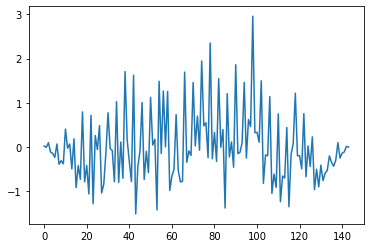